## Here, we make the lane detection model:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
from torch.utils.data import random_split, Subset
from sklearn.model_selection import KFold
import statistics
import cv2
import numpy as np
import matplotlib.pyplot as plt

Import images:

In [2]:
label_paths = sorted(glob.glob('./labels/*.jpg'))
image_paths = sorted(glob.glob('./frames_subset/*.jpg'))

Preprocess data:

In [3]:
def binarise(label):
    return (label > 0).float()

In [4]:
class LaneDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = binarise(mask)

        return image, mask

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Split data:

In [6]:
lane_data = LaneDataset(image_paths, label_paths, transform=transform)

train_size = int(0.8 * len(lane_data))
test_size = len(lane_data) - train_size

lane_train, lane_test = random_split(lane_data, [train_size, test_size])

In [7]:
dataloader_test = DataLoader(lane_test, batch_size=1, shuffle=False)

Make CNN model:

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.upsample(x)
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(x)
        return x

Training loop:

In [9]:
accs = []
k_fold = KFold(n_splits=8, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(k_fold.split(range(train_size))):
    
    train_subset = Subset(lane_train, train_ids)
    val_subset = Subset(lane_train, val_ids)

    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)

    model = CNN()
    criterion = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(10):
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)

            loss = criterion(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

    with torch.no_grad():
        n_correct_px = 0
        n_samples_px = 0
        for i, (images, labels) in enumerate(val_loader):
            outputs = model(images)
        
            preds = outputs > 0.5
            n_correct_px += (preds == labels).sum().item()
            n_samples_px += torch.numel(labels)
        accs.append((n_correct_px/n_samples_px))

avg_acc = statistics.mean(accs)
print(f'Cross-validation accuracy: {avg_acc}')        

Cross-validation accuracy: 0.9682025909423828


Evaluation loop:

In [10]:
model.eval()

with torch.no_grad():
    pixel_correct = 0
    pixel_total = 0
    iou_sum = 0

    for images, labels in dataloader_test:
        outputs = model(images)
        preds = outputs > 0.5

        preds_bool = preds.bool()
        labels_bool = labels.bool()

        pixel_correct += (preds_bool == labels_bool).sum().item()
        pixel_total += torch.numel(labels_bool)

        # IoU for each batch
        intersection = (preds_bool & labels_bool).float().sum((1, 2))
        union = (preds_bool | labels_bool).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_sum += iou.sum().item()


pixel_acc = pixel_correct / pixel_total
mean_iou = iou_sum / len(dataloader_test.dataset)

print(f'Pixel Accuracy: {pixel_acc}')
print(f'Mean IoU: {mean_iou}')

Pixel Accuracy: 0.9859619140625
Mean IoU: 169.01373291015625


Display results:

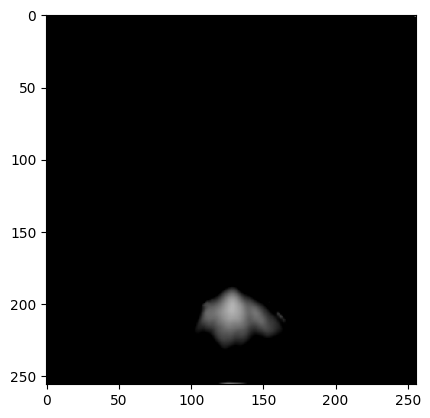

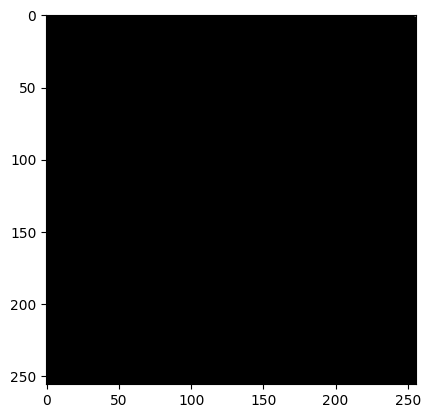

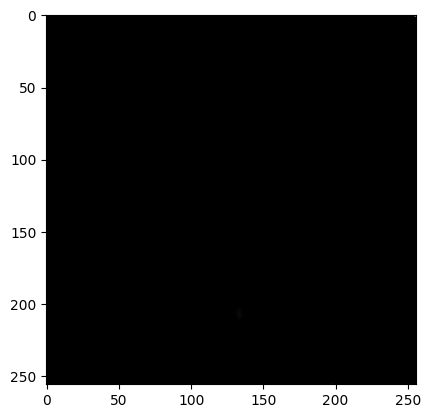

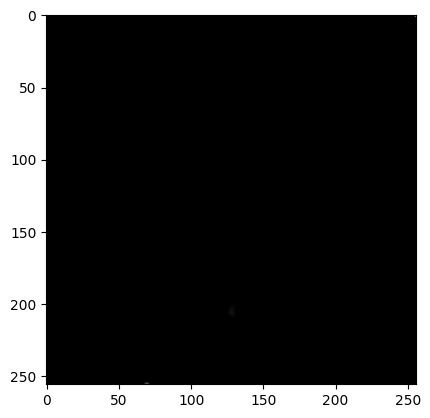

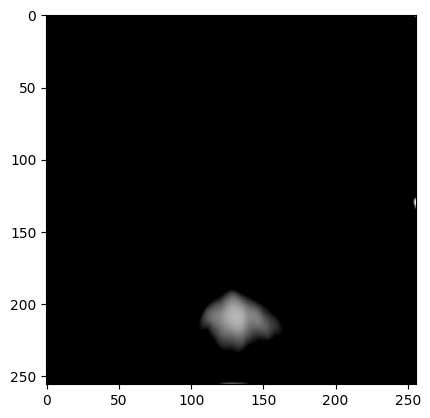

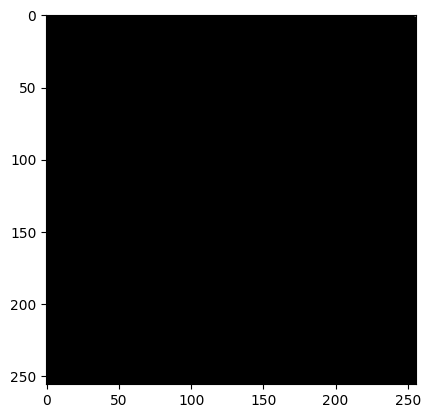

In [14]:
for i, (images, labels) in enumerate(train_loader):
    if i > 5:
        break
    outputs = model(images)
    plt.imshow(outputs.squeeze().cpu().detach().numpy()*255, cmap='gray')
    plt.show()

Use model on whole video:

In [12]:
cap = cv2.VideoCapture('lane_data.mp4')
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (frame_width, frame_height)
output_fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('lane_marked1.mp4', cv2.VideoWriter_fourcc(*'MP4V'), output_fps, frame_size)

In [13]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original_size = frame.shape[:3]
    input_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    input_frame_tf = transform(Image.fromarray(input_frame)).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_frame_tf)
        mask = (output.squeeze()).numpy()
        resized_mask = cv2.resize(mask, (original_size[1], original_size[0]))

    scaled_mask = (resized_mask * 255).astype(np.uint8)

    #colored_mask = np.zeros((720, 1280, 3), dtype=np.uint8)
    colored_mask = cv2.cvtColor(scaled_mask, cv2.COLOR_GRAY2BGR)
    colored_mask[resized_mask > 0.5] = [0, 0, 255]


    overlayed_frame = cv2.addWeighted(frame, 1, colored_mask, 0.5, 0)
    out.write(overlayed_frame)

cap.release()
out.release()